## Implementing C-BoW manually

In [1]:
## Importing the necessary libraries
import re
import numpy as np
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# loading the data
inp_data ="Since the so-called statistical revolution in the late 1980s and mid-1990s, much natural language processing research has relied heavily on machine learning. The machine-learning paradigm calls instead for using statistical inference to automatically learn such rules through the analysis of large corpora (the plural form of corpus, is a set of documents, possibly with human or computer annotations) of typical real-world examples.Many different classes of machine-learning algorithms have been applied to natural-language-processing tasks. These algorithms take as input a large set of features that are generated from the input data. Increasingly, however, research has focused on statistical models, which make soft, probabilistic decisions based on attaching real-valued weights to each input feature (complex-valued embeddings,[17] and neural networks in general have also been proposed, for e.g. speech[18]). Such models have the advantage that they can express the relative certainty of many different possible answers rather than only one, producing more reliable results when such a model is included as a component of a larger system.Some of the earliest-used machine learning algorithms, such as decision trees, produced systems of hard if-then rules similar to existing hand-written rules. However, part-of-speech tagging introduced the use of hidden Markov models to natural language processing, and increasingly, research has focused on statistical models, which make soft, probabilistic decisions based on attaching real-valued weights to the features making up the input data. The cache language models upon which many speech recognition systems now rely are examples of such statistical models. Such models are generally more robust when given unfamiliar input, especially input that contains errors (as is very common for real-world data), and produce more reliable results when integrated into a larger system comprising multiple subtasks.Since the neural turn, statistical methods in NLP research have been largely replaced by neural networks. However, they continue to be relevant for contexts in which statistical interpretability and transparency is required.A major drawback of statistical methods is that they require elaborate feature engineering. Since 2015,[19] the field has thus largely abandoned statistical methods and shifted to neural networks for machine learning. Popular techniques include the use of word embeddings to capture semantic properties of words, and an increase in end-to-end learning of a higher-level task (e.g., question answering) instead of relying on a pipeline of separate intermediate tasks (e.g., part-of-speech tagging and dependency parsing). In some areas, this shift has entailed substantial changes in how NLP systems are designed, such that deep neural network-based approaches may be viewed as a new paradigm distinct from statistical natural language processing. For instance, the term neural machine translation (NMT) emphasizes the fact that deep learning-based approaches to machine translation directly learn sequence-to-sequence transformations, obviating the need for intermediate steps such as word alignment and language modeling that was used in statistical machine translation (SMT)."

In [3]:
# remove special characters
inp_data2 = re.sub('[^A-Za-z0-9]+', ' ', inp_data)

# remove 1 letter words
inp_data2 = re.sub(r'(?:^| )\w(?:$| )', ' ', inp_data2).strip()

# lower all characters
inp_data2 = inp_data2.lower()

In [4]:
inp_data2

'since the so called statistical revolution in the late 1980s and mid 1990s much natural language processing research has relied heavily on machine learning the machine learning paradigm calls instead for using statistical inference to automatically learn such rules through the analysis of large corpora the plural form of corpus is set of documents possibly with human or computer annotations of typical real world examples many different classes of machine learning algorithms have been applied to natural language processing tasks these algorithms take as input large set of features that are generated from the input data increasingly however research has focused on statistical models which make soft probabilistic decisions based on attaching real valued weights to each input feature complex valued embeddings 17 and neural networks in general have also been proposed for g speech 18 such models have the advantage that they can express the relative certainty of many different possible answe

In [5]:
tokens = inp_data2.split()
vocab = set(tokens)

In [6]:
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

In [7]:
context_size = 4 #Hyper-parameter
batch_size = 8
embedding_size = 10 #Hyper-parameter
vocab_size = len(vocab) #Number of unique tokens in the vocabulary

In [8]:
embedding_size, vocab_size

(10, 240)

In [9]:
data = []

for i in range(context_size, len(tokens) - context_size):
  target = tokens[i]
  context = []
  for j in range(1, context_size+1):
    context += [tokens[i-j], tokens[i+j]]  
  data.append((context, target))

print(data[:5])

[(['called', 'revolution', 'so', 'in', 'the', 'the', 'since', 'late'], 'statistical'), (['statistical', 'in', 'called', 'the', 'so', 'late', 'the', '1980s'], 'revolution'), (['revolution', 'the', 'statistical', 'late', 'called', '1980s', 'so', 'and'], 'in'), (['in', 'late', 'revolution', '1980s', 'statistical', 'and', 'called', 'mid'], 'the'), (['the', '1980s', 'in', 'and', 'revolution', 'mid', 'statistical', '1990s'], 'late')]


In [10]:
len(data)

474

In [11]:
# Initialize Weights and Bias matrices
def initialize_weights(vocab_size, embedding_size):
  W1 = np.random.rand(embedding_size, vocab_size)
  W2 = np.random.rand(vocab_size, embedding_size)
  b1 = np.random.rand(embedding_size, 1)
  b2 = np.random.rand(vocab_size, 1)
  return W1, b1, W2, b2

In [12]:
def softmax_activation(z):
  return np.exp(z)/np.sum(np.exp(z), axis=0)

In [13]:
# Forward Propagation:
# 1. Linear Hidden State: h = W1.x + b1
# 2. Output Layer:        z = W2.h + b2
# 3. Softmax Activation:  z = softmax_activation(z)

def forward_propagation(X, W1, W2, b1, b2):
  # Compute Hidden Layer values
  h = np.dot(W1, X) + b1
  # Compute Output Layer Values
  z = np.dot(W2, h) + b2
  return z, h

In [14]:
def transform_data(context_words, target_word, vocab_size):
  input_vector = np.zeros((vocab_size, 1))
  target_vector = np.zeros((vocab_size, 1))
  
  for word in context_words:
    input_vector[word_to_index[word]] += 1
  
  input_vector = input_vector/len(context_words)

  target_vector[word_to_index[target_word]]=1

  return input_vector.reshape(1, -1), target_vector.reshape(1, -1)

In [15]:
def transform_batch_data(batch_data, vocab_size):
  X=np.zeros((vocab_size, len(batch_data)))
  y=np.zeros((vocab_size, len(batch_data)))

  for i in range(len(batch_data)):
    context_words = batch_data[i][0]
    target_word = batch_data[i][1]

    X[:, i], y[:, i] = transform_data(context_words, target_word, vocab_size)

  return X, y

In [16]:
def get_batch_indices(data, batch_size):
  batch_indices = []

  for i in range(0, len(data), batch_size):
    if (i+batch_size <= len(data)):
      batch_indices.append((i, i+batch_size))
    else:
      batch_indices.append((i, len(data)))
  return batch_indices

In [17]:
batch_indices = get_batch_indices(data, batch_size)

batch_indices

[(0, 8),
 (8, 16),
 (16, 24),
 (24, 32),
 (32, 40),
 (40, 48),
 (48, 56),
 (56, 64),
 (64, 72),
 (72, 80),
 (80, 88),
 (88, 96),
 (96, 104),
 (104, 112),
 (112, 120),
 (120, 128),
 (128, 136),
 (136, 144),
 (144, 152),
 (152, 160),
 (160, 168),
 (168, 176),
 (176, 184),
 (184, 192),
 (192, 200),
 (200, 208),
 (208, 216),
 (216, 224),
 (224, 232),
 (232, 240),
 (240, 248),
 (248, 256),
 (256, 264),
 (264, 272),
 (272, 280),
 (280, 288),
 (288, 296),
 (296, 304),
 (304, 312),
 (312, 320),
 (320, 328),
 (328, 336),
 (336, 344),
 (344, 352),
 (352, 360),
 (360, 368),
 (368, 376),
 (376, 384),
 (384, 392),
 (392, 400),
 (400, 408),
 (408, 416),
 (416, 424),
 (424, 432),
 (432, 440),
 (440, 448),
 (448, 456),
 (456, 464),
 (464, 472),
 (472, 474)]

In [18]:
# compute_cost: cross-entropy cost functioN
def compute_cost(y, yhat, batch_size):
    # cost function 
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [19]:
def back_propagation(X, y_hat, y, h, W1, W2, b1, b2, batch_size):
    
    l1 = np.dot(W2.T,(y_hat-y))
    
    grad_W1 = (1/batch_size)*np.dot(l1, X.T) 
    
    grad_W2 = (1/batch_size)*np.dot(y_hat-y, h.T)
    
    grad_b1 = np.sum((1/batch_size)*np.dot(l1, X.T), axis=1, keepdims=True)
    
    grad_b2 = np.sum((1/batch_size)*np.dot(y_hat-y,h.T), axis=1, keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [20]:
alpha = 0.3

W1, b1, W2, b2 = initialize_weights(vocab_size, embedding_size)

batch_indices = get_batch_indices(data, batch_size)

for i in range(1000):
  for start_index, end_index in batch_indices:
    X, y = transform_batch_data(data[start_index:end_index], vocab_size)
    z, h = forward_propagation(X, W1, W2, b1, b2)
    y_hat = softmax_activation(z)
    cost = compute_cost(y, y_hat, batch_size)

    grad_W1, grad_W2, grad_b1, grad_b2 = back_propagation(X, y_hat, y, h, W1, W2, b1, b2, batch_size)
          
    # Update weights and biases
    W1 -= alpha*grad_W1 
    W2 -= alpha*grad_W2
    b1 -= alpha*grad_b1
    b2 -= alpha*grad_b2
  print("Cost: ", cost, " after Iteration#: ", i+1)

Cost:  1.2594796895172777  after Iteration#:  1
Cost:  1.2514716664671797  after Iteration#:  2
Cost:  1.2473838806610942  after Iteration#:  3
Cost:  1.2438757270805758  after Iteration#:  4
Cost:  1.2404989835755162  after Iteration#:  5
Cost:  1.2371330519070056  after Iteration#:  6
Cost:  1.2337221794535727  after Iteration#:  7
Cost:  1.230228157092927  after Iteration#:  8
Cost:  1.226620989035212  after Iteration#:  9
Cost:  1.2228771323254  after Iteration#:  10
Cost:  1.218979208933479  after Iteration#:  11
Cost:  1.214915990266805  after Iteration#:  12
Cost:  1.2106824353206582  after Iteration#:  13
Cost:  1.2062797343473046  after Iteration#:  14
Cost:  1.2017153213129073  after Iteration#:  15
Cost:  1.197002804472637  after Iteration#:  16
Cost:  1.1921617511511  after Iteration#:  17
Cost:  1.1872172557151466  after Iteration#:  18
Cost:  1.1821992214076276  after Iteration#:  19
Cost:  1.1771412996121975  after Iteration#:  20
Cost:  1.1720794557464775  after Iterati

Cost:  0.08915786551010761  after Iteration#:  169
Cost:  0.08734148244807029  after Iteration#:  170
Cost:  0.08558306449131747  after Iteration#:  171
Cost:  0.08388057602522546  after Iteration#:  172
Cost:  0.08223206579504472  after Iteration#:  173
Cost:  0.08063566267553077  after Iteration#:  174
Cost:  0.07908957175607002  after Iteration#:  175
Cost:  0.07759207070249155  after Iteration#:  176
Cost:  0.07614150634916597  after Iteration#:  177
Cost:  0.07473629147357061  after Iteration#:  178
Cost:  0.07337490170915188  after Iteration#:  179
Cost:  0.07205587255972512  after Iteration#:  180
Cost:  0.07077779648824055  after Iteration#:  181
Cost:  0.06953932006310007  after Iteration#:  182
Cost:  0.06833914115501533  after Iteration#:  183
Cost:  0.06717600618576379  after Iteration#:  184
Cost:  0.06604870743649352  after Iteration#:  185
Cost:  0.06495608042727927  after Iteration#:  186
Cost:  0.06389700138146569  after Iteration#:  187
Cost:  0.06287038478832592  aft

Cost:  0.01672611154566705  after Iteration#:  330
Cost:  0.01659129739826223  after Iteration#:  331
Cost:  0.01645789013406138  after Iteration#:  332
Cost:  0.01632587930064123  after Iteration#:  333
Cost:  0.016195254284569895  after Iteration#:  334
Cost:  0.01606600432292348  after Iteration#:  335
Cost:  0.015938118514535464  after Iteration#:  336
Cost:  0.01581158583096125  after Iteration#:  337
Cost:  0.015686395127153273  after Iteration#:  338
Cost:  0.015562535151835945  after Iteration#:  339
Cost:  0.015439994557581382  after Iteration#:  340
Cost:  0.015318761910572753  after Iteration#:  341
Cost:  0.015198825700061591  after Iteration#:  342
Cost:  0.015080174347512298  after Iteration#:  343
Cost:  0.014962796215434008  after Iteration#:  344
Cost:  0.014846679615903946  after Iteration#:  345
Cost:  0.014731812818779003  after Iteration#:  346
Cost:  0.014618184059600952  after Iteration#:  347
Cost:  0.014505781547198011  after Iteration#:  348
Cost:  0.014394593

Cost:  0.006199825146898399  after Iteration#:  494
Cost:  0.0061741372976090395  after Iteration#:  495
Cost:  0.006148662013472682  after Iteration#:  496
Cost:  0.006123396757452229  after Iteration#:  497
Cost:  0.006098339025032326  after Iteration#:  498
Cost:  0.006073486343860216  after Iteration#:  499
Cost:  0.006048836273392843  after Iteration#:  500
Cost:  0.006024386404546157  after Iteration#:  501
Cost:  0.006000134359347733  after Iteration#:  502
Cost:  0.005976077790592543  after Iteration#:  503
Cost:  0.005952214381502513  after Iteration#:  504
Cost:  0.005928541845387429  after Iteration#:  505
Cost:  0.005905057925311288  after Iteration#:  506
Cost:  0.005881760393758358  after Iteration#:  507
Cost:  0.005858647052306131  after Iteration#:  508
Cost:  0.005835715731296542  after Iteration#:  509
Cost:  0.005812964289513416  after Iteration#:  510
Cost:  0.005790390613860944  after Iteration#:  511
Cost:  0.00576799261904442  after Iteration#:  512
Cost:  0.005

Cost:  0.0036813501588065962  after Iteration#:  657
Cost:  0.0036719616386795143  after Iteration#:  658
Cost:  0.00366261664862561  after Iteration#:  659
Cost:  0.0036533148822970977  after Iteration#:  660
Cost:  0.0036440560365674137  after Iteration#:  661
Cost:  0.003634839811483533  after Iteration#:  662
Cost:  0.0036256659102194724  after Iteration#:  663
Cost:  0.003616534039031197  after Iteration#:  664
Cost:  0.003607443907210654  after Iteration#:  665
Cost:  0.00359839522704233  after Iteration#:  666
Cost:  0.0035893877137594876  after Iteration#:  667
Cost:  0.0035804210855015163  after Iteration#:  668
Cost:  0.0035714950632725353  after Iteration#:  669
Cost:  0.003562609370899065  after Iteration#:  670
Cost:  0.0035537637349908387  after Iteration#:  671
Cost:  0.0035449578849003262  after Iteration#:  672
Cost:  0.0035361915526835475  after Iteration#:  673
Cost:  0.0035274644730621503  after Iteration#:  674
Cost:  0.003518776383385623  after Iteration#:  675
Co

Cost:  0.0025710692756343747  after Iteration#:  820
Cost:  0.0025661666883879082  after Iteration#:  821
Cost:  0.002561281107535264  after Iteration#:  822
Cost:  0.00255641244968369  after Iteration#:  823
Cost:  0.0025515606319698623  after Iteration#:  824
Cost:  0.0025467255720546724  after Iteration#:  825
Cost:  0.0025419071881202437  after Iteration#:  826
Cost:  0.0025371053988657135  after Iteration#:  827
Cost:  0.0025323201235013014  after Iteration#:  828
Cost:  0.0025275512817465534  after Iteration#:  829
Cost:  0.002522798793824851  after Iteration#:  830
Cost:  0.0025180625804595846  after Iteration#:  831
Cost:  0.0025133425628710336  after Iteration#:  832
Cost:  0.0025086386627709983  after Iteration#:  833
Cost:  0.002503950802360008  after Iteration#:  834
Cost:  0.0024992789043232584  after Iteration#:  835
Cost:  0.0024946228918263187  after Iteration#:  836
Cost:  0.0024899826885122277  after Iteration#:  837
Cost:  0.0024853582184967225  after Iteration#:  83

Cost:  0.0019642254483935064  after Iteration#:  978
Cost:  0.001961235808332141  after Iteration#:  979
Cost:  0.001958254598280581  after Iteration#:  980
Cost:  0.00195528178436066  after Iteration#:  981
Cost:  0.001952317332868748  after Iteration#:  982
Cost:  0.0019493612102744757  after Iteration#:  983
Cost:  0.0019464133832197525  after Iteration#:  984
Cost:  0.0019434738185177144  after Iteration#:  985
Cost:  0.0019405424831517339  after Iteration#:  986
Cost:  0.0019376193442740552  after Iteration#:  987
Cost:  0.0019347043692051155  after Iteration#:  988
Cost:  0.0019317975254322644  after Iteration#:  989
Cost:  0.001928898780608818  after Iteration#:  990
Cost:  0.0019260081025530592  after Iteration#:  991
Cost:  0.0019231254592472794  after Iteration#:  992
Cost:  0.0019202508188361916  after Iteration#:  993
Cost:  0.0019173841496271308  after Iteration#:  994
Cost:  0.0019145254200875332  after Iteration#:  995
Cost:  0.0019116745988458363  after Iteration#:  996

In [21]:
W1.T.shape, W2.shape

((240, 10), (240, 10))

In [22]:
((W1.T+ W2)/2).shape

(240, 10)

### Visualizing word vectors with t-sne

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

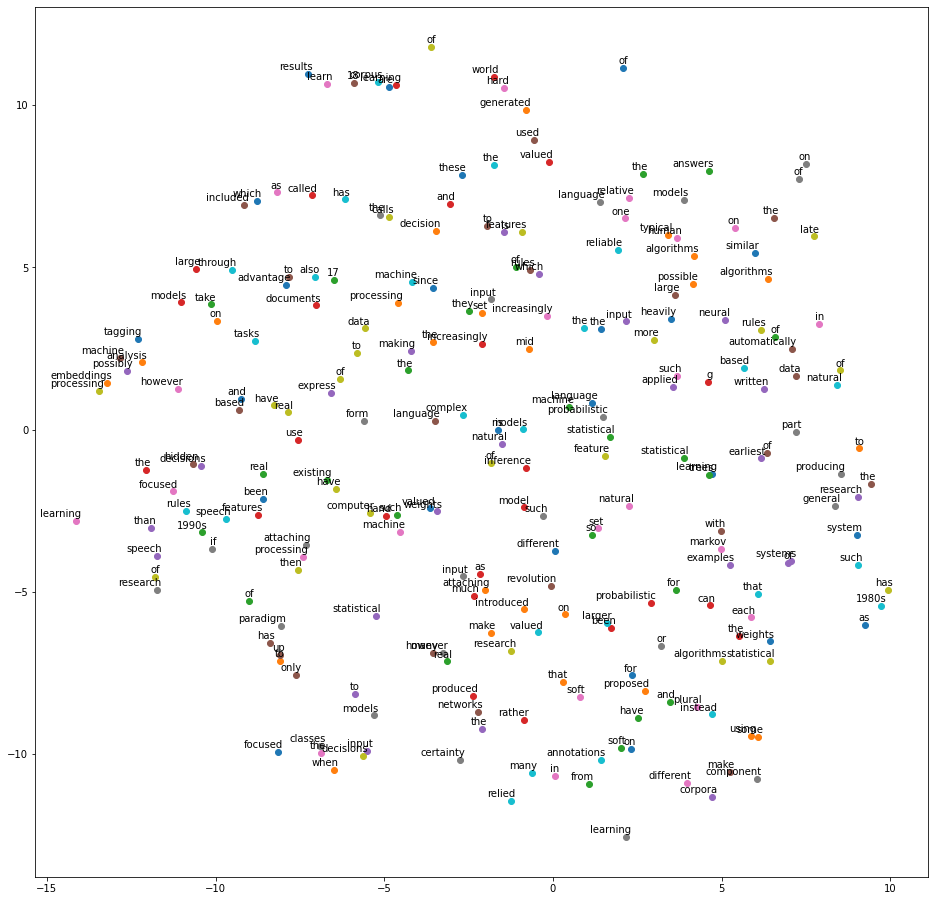

In [24]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(((W1.T+ W2)/2))

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(tokens[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()